In [1]:
reset()

# Auxiliary functions

 We set, $\Phi_1(x)=x-1$ and  $\Phi_N(x) = D(x)/\Phi_1(x).$<br>
$N$ is prime, and $q\le 16N/3+16$ which is a power of two,
 $D(x)=x^N-1.$<br><br>
`GenKey(seed)`. Takes as input a *seed* and outputs a quadruple
`(pk,sk)`=$({\textbf h},({\textbf f},{\textbf f}_3,{\textbf h}_q)).$\
\
`1.` $(f(x),g(x))\xleftarrow{\$} {\mathcal{L}}_f\times {\mathcal{L}}_g$
\# `here we use the seed`\
`2.` $f_q(x)\leftarrow f^{-1}(x)\mod{(q,\Phi_N(x))}$ \# $\Phi_N(x)=x^{N-1}+\cdots x+1$\
`3.` $f_3(x)\leftarrow f^{-1}(x)\mod{(3,\Phi_N(x))}$\
`4.` $h(x) \leftarrow 3g(x)*f_q(x)\mod{(q,D(x))}$  $\# D(x)=x^N-1$\
`5.` $h_q(x) \leftarrow h^{-1}(x)\mod{(q,\Phi_N(x))}$ \
`6.` ${\mathbb{S}} \xleftarrow{\$} \{0,1\}^{256}$ \
`7.` **return**
 $(pk,sk)=({\textbf h},({\textbf f},{\textbf f}_3,{\textbf h}_q,{\mathbb{S}}))$


We also need to define the sample sets.<br>
With ${\mathcal{T}}_a$ we denote the set of **ternary** polynomials of
${\mathcal{R}}={\mathbb{Z}}[z]/(x^a-1)$ with degree at most $a-1$ and
$\mathcal{T}_a(d_1,d_2)\subset {\mathcal{T}}_{a}$ consists from elements
of ${\mathcal{T}}_{a}$ with $d_1$ coefficients equal to $1$ and $d_2$
equal to $-1.$ Furthermore, with
${\mathcal{T}}_a(w), w\in{\mathbb{Z}}_{>0}$ we denote the ternary
polynomials which have $w$ non-zero coefficients. We also have four sample spaces,
${\mathcal{L}}_f, {\mathcal{L}}_g, {\mathcal{L}}_r,$ and ${\mathcal{L}}_m.$\
$-$ ${\mathcal{L}}_m={\mathcal{L}}_g=
{\mathcal{T}}_{N-2}\big(\frac{q}{16}-1,\frac{q}{16}-1\big),$\
$-$ ${\mathcal{L}}_f={\mathcal{L}}_r={\mathcal{T}}_{N-2}.$


# Key Generation/Encrypt/Decrypt

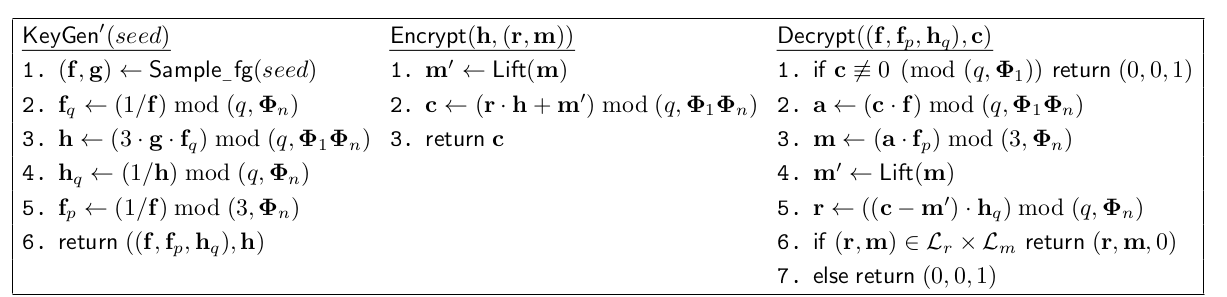

In [2]:
def bits(N):
    if N==0:
        return 0
    else:
        return floor(log(N,2))+1

def pad_binary(bin_str):
    return '0' * (11 - len(bin_str)) + bin_str    

def count_equal(L1,L2):
    return sum(x == y for x, y in zip(L1, L2))

def correction_of_msg(N,m):
    '''
    N: the parameter of NTRU
    m: the message polynomial
    Output: a list of length N with the coefficients of m(x)
    '''
    m_list=m.list()
    if len(m_list)<N:
        diff = N - len(m_list)
        m_list.append(diff*[0])
    return flatten(m_list)

def random32(): return randrange(-2^31,2^31)        # a random integer in -2^31 and 2^31

def randomrange3():  
    ''' 
    generate a random integer in {0, 1, 2} 
    by utilizing a 32-bit random number generator : random32()
    '''
    return ((random32() & 0x3fffffff) * 3) >> 30


# we generate ternary polynomials of degre at most with d1 one and d2 minus one
def T(d1,d2,N):
    import random
    Zx.<x> = ZZ[]    
    a = d1*[1]
    b = d2*[-1]
    c = (N+2-d1-d2)*[0] #the length must be N+1 to get a polynomial of degree at most N
    L = flatten([a,b,c])
    random.shuffle(L) 
    return L,Zx(L)
    
def CenterLift(f,q,N):    
    f_balanced = list(   ((f[i]+q//2)%q) -q//2  for i in range(N)   )
    return Zx(f_balanced)

def reduce_mod_PhiN_and_modq(f):
    return Zx(S(f).lift())%q

def reduce_mod_DN_and_modq(f): # if f=G*F then we get the multiplication of G and F in R/(q,x^N-1) 
    return Zx(R(f).lift())%q

def Convolution_in_S_q(f,g,N,q): 
    PhiN=sum(x^i for i in [0..N-1])
    h = (f*g)%(PhiN)
    return  Zx(h)%q  

def Convolution_in_S(f,g,N):
    PhiN=sum(x^i for i in [0..N-1])
    h = (f*g)%(PhiN)
    #h1 = list( (h[i]%q)   for i in range(N) )
    return  Zx(h) 

def Invertmodprime_and_phiN(f,p,N):        #p must be prime
    phiN = sum(x^i for i in [0..N-1])
    if is_prime(p)==False:
        return "error"
    T = Zx.change_ring(Integers(p)).quotient(PhiN)
    return Zx(lift(1/T(f)))

def invert_mod_2_and_phiN(f):
    return Zx( (1/S2(f)).lift())

def Invertmodpowerofprime_mod_PhiN(f,Q,e,N): # Q prime, e: exponent
    F = invert_mod_2_and_phiN(f)
    if e == 1:      
        return F
    temp_exponent = 2
    while e>0:
        temp = Convolution_in_S(F,f,N)
        F = Convolution_in_S_q(F,2-temp,N,Q^temp_exponent)
        e = floor(e/2)
        temp_exponent = 2*temp_exponent
    return F

def Invert_mod3_and_PhiN(f):
    T = 1/S3(f)
    return T    

def private_keys(N):
    # for L_g we choose d=q/16-1
    # for L_f we choose T_{N-2}
    while True:
        f = Zx([randomrange3()-1 for i in range(N-1)])
        if S3(f).is_unit(): break
    d=q/16-1;g = T(d,d,N-2)
    return f,g[1]

def gen_keys(N,q): 
    f,g=private_keys(N);
    base_of_q = 2
    exponent  = int(log(q,2))
    # N is prime
    # We have set : q = (base_of_q)^(exponent)
    
    try:
        fq=Invertmodpowerofprime_mod_PhiN(f,base_of_q,exponent,N)
    except ZeroDivisionError:
        print("Oops! there is not inverse of f in S_{0}".format(q))
        return _,_,_,_,_,_
    try:
        f3 = Invert_mod3_and_PhiN(f)
    except ZeroDivisionError:
        print("Oops! there is not inverse of f in S_{0}".format(3))
        return _,_,_,_,_,_
    fq = fq%q
    h   = 3*reduce_mod_DN_and_modq(fq * g); # public key, we work mod<q,x^N-1>
    try: 
        hq=Invertmodpowerofprime_mod_PhiN(h,base_of_q,exponent,N)
    except ZeroDivisionError:
        print("Oops! there is not inverse of h in S_{0}".format(q))
        return
    hq = hq%q
    return h,f,Zx(f3.lift()),hq,g,fq

### Encryption
def enc(N,q,msg,h):
    r = Zx([randomrange3()-1 for i in range(N-1)]) #ephemeral key, a ternary of degree <=N-2
    ct1=reduce_mod_DN_and_modq(h*r)  # mod <q,x^N-1>
    ct = reduce_mod_DN_and_modq(ct1 + msg)   # mod <q,x^N-1>
    #print("r={0}\nct1={1}\nmsg={2}\nct={3}".format(r,ct1,msg,ct))
    return ct,r

### decryption
def decryption(ct,f,m):
    a=reduce_mod_DN_and_modq(ct * f)
    a=CenterLift(a,q,N)
    if S3(a*f3)==S3(m):
        print("decryption OK")
    return Zx(S3(a*f3).lift())


In [3]:
# parameters for NTRU-HPS 
# returns N and q
def ntruhps(x):
    if x==1:
        return 509,2048 #ntruhps2048509
    if x==2:
        return 677,2048
    if x==3:
        return 821,4096
N,q=ntruhps(2)

In [4]:
print("N,q=",N,q)
print(q/8 - 1<=2*N/3)
D,PhiN=x^N-1,sum(x^i for i in [0..N-1])

Zx.<x> = ZZ[]
R.<xN> = Zx.quotient(D)
S.<XN> = Zx.quotient(PhiN)

F3 = GF(3); 
F3x.<x3> = F3[]; 
Phi3N = sum(x3^i for i in [0..N-1])
S3.<X3> = F3x.quotient(Phi3N)

F2 = GF(2); F2x.<x2> = F2[]
Phi2N=sum(x2^i for i in [0..N-1])
S2.<X2> = F2x.quotient(Phi2N)


N,q= 677 2048
True


# The Attack<br>
The first step is to define the matrix 
$$ 
	M_k=
    \left[\begin{array}{c|c}
	I_N & -kI_N  \\
	\hline
	{\textbf 0}_N & qI_N   \\
	\end{array}\right].
    $$
    
Note that $b(x)=kc(x)$ so $b_i=kc_i.$<br>
We know  that $${\bf u}=(u_1,...,u_n)\in\{k-b_i , - b_i  , - k -b_i\}^N.$$
We have the ciphertext $c(x)$ and the public key $h(x).$ The encryption equation is $c(x)=r(x)*h(x)+m(x).$ Multiplying both sides with the integer $-k$ (for some positive $k$) we get 
$$
km(x)=b(x)+u(x),\text{ where } u(x)=-kr(x)*h(x) \text{ and } b(x)=k c(x) \ \text{in}\ {\mathcal{R}}/q.
$$
Therefore,  the previous equation in ${\mathcal{R}}$ is written
$$km(x)=b(x)+u(x)+qv(x),\text{ for some } v(x)\in {\mathcal{R}}.$$
In this equation, polynomials $m(x), u(x)$ are unknown.
We first remark that $b(x)+u(x)$ has its coefficients in $\{-k,0,k\}$. This is evident since $m(x)$ is ternary polynomial. So, the unknown polynomial $u(x)$ has the coefficient of $x^{i}$ in $\{k-b_i,-b_i,-k-b_i\},$ where $b_i$ are the coefficients of $b(x).$ 
 Say that $q=2048$<br> 
 **The new attack**<br>
 We assume that:<br>
 (1) we know the binary lenght of the entries $(u_i)$ of ${\bf u}.$ Since ${\bf u}\in {\mathbb{Z}}_q^N$ the binary length of each $u_i$ is at most $bits(q)-1=10$, since $q=2^{11}.$ <br>
 (2) We know the MSB and LSB of $u_i$.<br>
 Then we can have a succesfull attack for ntruhps2048509, ntruhps2048677.<br>

In [5]:
# construct M_k
# ************* #
def Mk(N,q,k):
    I=identity_matrix(N)
    Zero_Matrix=matrix(N)
    H=-k*I
    B_1=block_matrix([[I,H]])       
    B_2=block_matrix([[Zero_Matrix,q*I]])
    M_NTRU=block_matrix([[B_1],[B_2]])
    return M_NTRU

def u_vector(h,r,kappa):
    # u : the unknown vector such that u(x)=-kappa(h(x)*r(x)) mod q
    u_list = [ x%q for x in R(-kappa*r*h).list()]
    u_vector = vector(u_list)     # write u as sage vector
    return u_vector

def betta(kappa,ct,N):
    b      = kappa*ct % q
    Blist  = b.coefficients(sparse=False)
    return Blist

def compute_I1_I2(E):
    I1=[]
    I2=[]
    for i in range(len(E)):
        if E[i]!=0:
            I1.append(i)
        else:
            I2.append(i)
    return I1,I2

In [6]:
from fpylll import IntegerMatrix,LLL,GSO
import random
import numpy as np

M = []
h,f,f3,hq,g,fq = gen_keys(N=N,q=q)
msg = T(q/16-1,q/16-1,N-2) # Since we want messages of weight q/8-2.
ct,r=enc(N,q,msg[1],h)     # the ciphertext and the ephemeral key
m = msg[1]                 # the message            
_=decryption(ct,f,m)       # we check if the decryption is correct

#print("N=",N)
#print("k=",kappa)

decryption OK


In [7]:
def first_step(kappa):
    M_k = Mk(N,q,kappa)
    u = u_vector(h,r,kappa)    
    Blist = betta(kappa,ct,N)
    A1 = [bin( (-x)%q)[2:] for x in Blist]
    A2 = [bin( (-x+kappa)%q)[2:] for x in Blist]
    A3 = [bin( (-x-kappa)%q)[2:] for x in Blist]
    u_bin = [bin(x)[2:] for x in list(u)]
    A1_padded = [pad_binary(x) for x in A1]
    A2_padded = [pad_binary(x) for x in A2]
    A3_padded = [pad_binary(x) for x in A3]
    u_padded  = [pad_binary(x) for x in u_bin]
    # experiment in ntruhps2048509
    E = [0] * len(u)
    for i in range(len(A1_padded)):
        bits1 = A1_padded[i][0:1] + A1_padded[i][-1:]
        bits2 = A2_padded[i][0:1] + A2_padded[i][-1:]
        bits3 = A3_padded[i][0:1] + A3_padded[i][-1:]         
        bitsu = u_padded[i][0:1] + u_padded[i][-1:]
         # Check if bits1 equals u
        if bits1 == bitsu:
            if bits2 != bits1 and bits3 != bits1:
                E[i] = u[i]
        # Check if bits2 equals u
        if bits2 == bitsu:
            if bits1 != bits2 and bits3 != bits2:
                E[i] = u[i]
        # Check if bits3 equals u
        if bits3 == bitsu:
            if bits1 != bits3 and bits2 != bits3:
                E[i] = u[i]
        #print(f"{i:<6}{A1_padded[i]:<20}{A2_padded[i]:<20}{A3_padded[i]:<20}{u_padded[i]:<20}")
    return E,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded

In [8]:
def second_step(kappa,temp_E0,N,A1_padded,A2_padded,A3_padded,u_padded):
    import copy
    def compute_I1_I2(E):
        I1=[]
        I2=[]
        for i in range(len(E)):
            if E[i]!=0:
                I1.append(i)
            else:
                I2.append(i)
        return I1,I2
    E = copy.copy(temp_E0)
    S = [0] * N
    I1,I2=compute_I1_I2(temp_E0)
    for i in I2:
        if E[i]==0:
            bits1 = A1_padded[i][0:1] + A1_padded[i][-1:]
            bits2 = A2_padded[i][0:1] + A2_padded[i][-1:]
            bits3 = A3_padded[i][0:1] + A3_padded[i][-1:]         
            bitsu = u_padded[i][0:1] + u_padded[i][-1:]
            if bitsu==bits1 and bitsu==bits2:
                S[i]=int( ( int(A1_padded[i],2) + int(A2_padded[i],2) )/2 )
                #S[i] = random.choice([int(A2_padded[i],2), int(A3_padded[i],2) ])
                #LEN =min(bits(int(A1_padded[i],2)),int(A2_padded[i],2))
                #S[i] = (2^(LEN-2))
                continue
            if bitsu==bits2 and bitsu==bits3:
                S[i]=int( ( int(A2_padded[i],2) + int(A3_padded[i],2) )/2 )
                #S[i] = random.choice([int(A2_padded[i],2), int(A3_padded[i],2) ])
                #LEN =min(bits(int(A2_padded[i],2)),int(A3_padded[i],2))
                #S[i] = (2^(LEN-2))
                continue            
            if bitsu==bits3 and bitsu==bits1:
                S[i]=int( ( int(A3_padded[i],2) + int(A1_padded[i],2) )/2 )  
                #S[i] = random.choice([int(A3_padded[i],2), int(A1_padded[i],2) ])
                #LEN =min(bits(int(A3_padded[i],2)),int(A1_padded[i],2))
                #S[i] = (2^(LEN-2))

    for i in I2:
        E[i]=S[i] 
    return E,S


In [9]:
def final_step(kappa,guessing_msg,E0):
    E_ = [0]*N + list(E0)
    if len(Blist)==N:
        target = vector(guessing_msg + Blist) + vector(E_)
    Mk_fplll=IntegerMatrix.from_matrix(M_k)
    M_GSO = GSO.Mat(Mk_fplll)
    M_GSO.update_gso()
    L_babai = M_GSO.babai(target) # we call Babai
    w_babai = sum(-L_babai[i]*M_k[i] for i in range(Mk_fplll.nrows)).list() # the output
    print("Success of the attack:",w_babai[0:N]==msg[0]) # we check if our atack found the message
    print("distance of target vector with the output:",(vector(target)+vector(w_babai)).norm().n())
    print("distance d(u,E):",(vector(u)-vector(E0)).norm().n())
    print("number of equal entries:",count_equal(w_babai[0:N],msg[0]))
    return w_babai[0:N]

In [10]:
kappa=201
temp_E0,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_11,I_12=compute_I1_I2(temp_E0)
E0,S0 = second_step(kappa,temp_E0,N,A1_padded,A2_padded,A3_padded,u_padded)
w0=final_step(kappa,[0]*N,E0)

Success of the attack: False
distance of target vector with the output: 10.4880884817015
distance d(u,E): 2412.00000000000
number of equal entries: 533


In [11]:
kappa=171
temp_E1,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_21,I_22=compute_I1_I2(temp_E1)
E1,S1 = second_step(kappa,temp_E1,N,A1_padded,A2_padded,A3_padded,u_padded)
w1=final_step(kappa,w0,E1)

#update w0
lst=[x for x in I_21 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w1[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_21)))

Success of the attack: False
distance of target vector with the output: 16.4620776331543
distance d(u,E): 2209.80700514773
number of equal entries: 510
50
583


In [12]:
I_31=[];I_32=[]
kappa=131
temp_E2,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_31,I_32=compute_I1_I2(temp_E2)
E2,S2 = second_step(kappa,temp_E2,N,A1_padded,A2_padded,A3_padded,u_padded)
w2=final_step(kappa,w1,E2)
#update w0
lst=[x for x in I_31 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w2[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_31)))

Success of the attack: False
distance of target vector with the output: 14.3874945699382
distance d(u,E): 1786.60180230515
number of equal entries: 491
23
606


In [13]:
kappa=97
temp_E3,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_41,I_42=compute_I1_I2(temp_E3)
E3,S3 = second_step(kappa,temp_E3,N,A1_padded,A2_padded,A3_padded,u_padded)
w3=final_step(kappa,w0,E3)
#update w0
lst=[x for x in I_41 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w3[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_41)))

Success of the attack: False
distance of target vector with the output: 16.4316767251550
distance d(u,E): 1435.46891293403
number of equal entries: 458
9
615


In [14]:
kappa=95
temp_E4,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_51,I_52=compute_I1_I2(temp_E4)
E4,S4 = second_step(kappa,temp_E4,N,A1_padded,A2_padded,A3_padded,u_padded)
w4=final_step(kappa,w0,E4)
#update w0
lst=[x for x in I_51 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w4[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_51)))

Success of the attack: False
distance of target vector with the output: 17.7763888346312
distance d(u,E): 1363.50650896870
number of equal entries: 471
10
625


In [15]:
kappa=93
temp_E5,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_61,I_62=compute_I1_I2(temp_E5)
E5,S5 = second_step(kappa,temp_E5,N,A1_padded,A2_padded,A3_padded,u_padded)
w5=final_step(kappa,w0,E5)
#update w0
lst=[x for x in I_61 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w5[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_61)))

Success of the attack: False
distance of target vector with the output: 17.9443584449264
distance d(u,E): 1328.30568770897
number of equal entries: 473
15
640


In [16]:
kappa=91
temp_E6,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_71,I_72=compute_I1_I2(temp_E6)
E6,S6 = second_step(kappa,temp_E6,N,A1_padded,A2_padded,A3_padded,u_padded)
w6=final_step(kappa,w0,E6)
#update w0
lst=[x for x in I_71 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w6[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_71)))

Success of the attack: False
distance of target vector with the output: 18.3303027798234
distance d(u,E): 1321.85135321639
number of equal entries: 466
5
645


In [17]:
kappa=89
temp_E7,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_81,I_82=compute_I1_I2(temp_E7)
E7,S7 = second_step(kappa,temp_E7,N,A1_padded,A2_padded,A3_padded,u_padded)
w7=final_step(kappa,w0,E7)
#update w0
lst=[x for x in I_81 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w7[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_81)))

Success of the attack: False
distance of target vector with the output: 18.4390889145858
distance d(u,E): 1289.73253041086
number of equal entries: 467
7
652


In [18]:
kappa=87
temp_E8,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_91,I_92=compute_I1_I2(temp_E8)
E8,S8 = second_step(kappa,temp_E8,N,A1_padded,A2_padded,A3_padded,u_padded)
w8=final_step(kappa,w0,E8)
#update w0
lst=[x for x in I_91 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w8[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_91)))

Success of the attack: False
distance of target vector with the output: 18.8944436276912
distance d(u,E): 1254.73184386147
number of equal entries: 469
5
657


In [19]:
kappa=85
temp_E9,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_101,I_102=compute_I1_I2(temp_E9)
E9,S9 = second_step(kappa,temp_E9,N,A1_padded,A2_padded,A3_padded,u_padded)
w9=final_step(kappa,w0,E9)
#update w0
lst=[x for x in I_101 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w9[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_101)))

Success of the attack: False
distance of target vector with the output: 18.9472953214964
distance d(u,E): 1228.83074505808
number of equal entries: 468
5
662


In [20]:
kappa=83
temp_E10,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_111,I_112=compute_I1_I2(temp_E10)
E10,S10 = second_step(kappa,temp_E10,N,A1_padded,A2_padded,A3_padded,u_padded)
w10=final_step(kappa,w0,E10)
#update w0
lst=[x for x in I_111 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w10[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_111)))

Success of the attack: False
distance of target vector with the output: 19.5448202856921
distance d(u,E): 1188.37914825194
number of equal entries: 472
2
664


In [21]:
kappa=81
temp_E11,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_121,I_122=compute_I1_I2(temp_E11)
E11,S11 = second_step(kappa,temp_E11,N,A1_padded,A2_padded,A3_padded,u_padded)
w11=final_step(kappa,w0,E11)
#update w0
lst=[x for x in I_121 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w11[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_121)))

Success of the attack: False
distance of target vector with the output: 19.6977156035922
distance d(u,E): 1159.74350612538
number of equal entries: 472
0
664


In [22]:
kappa=79
temp_E12,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_131,I_132=compute_I1_I2(temp_E12)
E12,S12 = second_step(kappa,temp_E12,N,A1_padded,A2_padded,A3_padded,u_padded)
w12=final_step(kappa,w0,E12)
#update w0
lst=[x for x in I_131 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w12[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_131)))

Success of the attack: False
distance of target vector with the output: 18.1383571472171
distance d(u,E): 1177.07348963436
number of equal entries: 455
4
668


In [23]:
kappa=77
temp_E13,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_141,I_142=compute_I1_I2(temp_E13)
E13,S13 = second_step(kappa,temp_E13,N,A1_padded,A2_padded,A3_padded,u_padded)
w13=final_step(kappa,w0,E13)
#update w0
lst=[x for x in I_141 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w13[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_141)))

Success of the attack: False
distance of target vector with the output: 19.1311264697090
distance d(u,E): 1123.77800298813
number of equal entries: 464
1
669


In [24]:
kappa=75
temp_E14,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_151,I_152=compute_I1_I2(temp_E14)
E14,S14 = second_step(kappa,temp_E14,N,A1_padded,A2_padded,A3_padded,u_padded)
w14=final_step(kappa,w0,E14)
#update w0
lst=[x for x in I_151 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w14[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_151)))

Success of the attack: False
distance of target vector with the output: 19.0787840283389
distance d(u,E): 1097.15541287458
number of equal entries: 463
1
670


In [25]:
kappa=63
temp_E15,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_161,I_162=compute_I1_I2(temp_E15)
E15,S15 = second_step(kappa,temp_E15,N,A1_padded,A2_padded,A3_padded,u_padded)
w15=final_step(kappa,w0,E15)
#update w0
lst=[x for x in I_161 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w15[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_161)))

Success of the attack: False
distance of target vector with the output: 17.8885438199983
distance d(u,E): 953.362994876558
number of equal entries: 448
1
671


In [26]:
kappa=59
temp_E16,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_171,I_172=compute_I1_I2(temp_E16)
E16,S16 = second_step(kappa,temp_E16,N,A1_padded,A2_padded,A3_padded,u_padded)
w16=final_step(kappa,w0,E16)
#update w0
lst=[x for x in I_171 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w16[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_171)))

Success of the attack: False
distance of target vector with the output: 18.8679622641132
distance d(u,E): 871.124560553771
number of equal entries: 459
0
671


In [27]:
kappa=303
temp_E17,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_181,I_182=compute_I1_I2(temp_E17)
E17,S17 = second_step(kappa,temp_E17,N,A1_padded,A2_padded,A3_padded,u_padded)
w17=final_step(kappa,w0,E17)
#update w0
lst=[x for x in I_181 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w17[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_181)))

Success of the attack: False
distance of target vector with the output: 26.2297540972080
distance d(u,E): 3119.57593271906
number of equal entries: 571
2
673


In [28]:
kappa=55
temp_E18,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_191,I_192=compute_I1_I2(temp_E18)
E18,S18 = second_step(kappa,temp_E18,N,A1_padded,A2_padded,A3_padded,u_padded)
w18=final_step(kappa,w0,E18)
#update w0
lst=[x for x in I_191 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w18[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_191)))

Success of the attack: False
distance of target vector with the output: 17.8605710994918
distance d(u,E): 832.301027273186
number of equal entries: 448
3
676


In [29]:
kappa=53
temp_E19,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_201,I_202=compute_I1_I2(temp_E19)
E19,S19 = second_step(kappa,temp_E19,N,A1_padded,A2_padded,A3_padded,u_padded)
w19=final_step(kappa,w0,E19)
#update w0
lst=[x for x in I_201 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w19[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_201)))

Success of the attack: False
distance of target vector with the output: 18.1107702762748
distance d(u,E): 802.035535372342
number of equal entries: 448
0
676


In [30]:
kappa=51
temp_E20,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_211,I_212=compute_I1_I2(temp_E20)
E20,S20 = second_step(kappa,temp_E20,N,A1_padded,A2_padded,A3_padded,u_padded)
w20=final_step(kappa,w0,E20)
#update w0
lst=[x for x in I_211 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w20[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_211)))

Success of the attack: False
distance of target vector with the output: 17.8605710994918
distance d(u,E): 776.808856798119
number of equal entries: 445
0
676


In [31]:
kappa=47
temp_E21,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_221,I_222=compute_I1_I2(temp_E21)
E21,S21 = second_step(kappa,temp_E21,N,A1_padded,A2_padded,A3_padded,u_padded)
w21=final_step(kappa,w0,E21)
#update w0
lst=[x for x in I_221 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w21[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_221)))

Success of the attack: False
distance of target vector with the output: 17.6918060129541
distance d(u,E): 718.961751416583
number of equal entries: 443
0
676


In [32]:
kappa=301
temp_E22,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_231,I_232=compute_I1_I2(temp_E22)
E22,S22 = second_step(kappa,temp_E22,N,A1_padded,A2_padded,A3_padded,u_padded)
w22=final_step(kappa,w0,E22)
#update w0
lst=[x for x in I_231 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w22[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_231)))

Success of the attack: False
distance of target vector with the output: 26.2297540972080
distance d(u,E): 3142.53225918208
number of equal entries: 568
0
676


In [33]:
kappa=333
temp_E23,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_241,I_242=compute_I1_I2(temp_E23)
E23,S23 = second_step(kappa,temp_E23,N,A1_padded,A2_padded,A3_padded,u_padded)
w23=final_step(kappa,w0,E23)
#update w0
lst=[x for x in I_241 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w23[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_241)))

Success of the attack: False
distance of target vector with the output: 28.1780056072107
distance d(u,E): 2845.15324719074
number of equal entries: 604
1
677


In [34]:
kappa=343
temp_E24,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_251,I_252=compute_I1_I2(temp_E24)
E24,S24 = second_step(kappa,temp_E24,N,A1_padded,A2_padded,A3_padded,u_padded)
w24=final_step(kappa,w0,E24)
#update w0
lst=[x for x in I_251 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w24[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_251)))

Success of the attack: False
distance of target vector with the output: 27.4226184016042
distance d(u,E): 3217.62521123887
number of equal entries: 589
0
677


In [35]:
kappa=443
temp_E25,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_261,I_262=compute_I1_I2(temp_E25)
E25,S25 = second_step(kappa,temp_E25,N,A1_padded,A2_padded,A3_padded,u_padded)
w25=final_step(kappa,w0,E25)
#update w0
lst=[x for x in I_261 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w25[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_261)))

Success of the attack: False
distance of target vector with the output: 30.1330383466387
distance d(u,E): 2658.00000000000
number of equal entries: 641
0
677


In [36]:
kappa=453
temp_E26,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa)
I_271,I_272=compute_I1_I2(temp_E26)
E26,S26 = second_step(kappa,temp_E26,N,A1_padded,A2_padded,A3_padded,u_padded)
w26=final_step(kappa,w0,E26)
#update w0
lst=[x for x in I_271 if x not in I_11]
print(len(lst))
for x in lst:
    w0[x]=w26[x]
T=0
for i in range(N):
    if (w0[i])==(msg[0][i]):
        #print(i,w0[i],msg[0][i])
        T=T+1
print(T)
# update I_11
I_11 = (list(set(I_11+I_271)))

Success of the attack: False
distance of target vector with the output: 30.1330383466387
distance d(u,E): 2718.00000000000
number of equal entries: 641
0
677


In [37]:
msg[0]==w0

True